# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd
import numpy as np

## Load the data into a DataFrame
# pd.read_csv()
liquor_path = '../Iowa_Liquor_sales_sample_10pct.csv'
liquor = pd.read_csv(liquor_path)
liquor.head()

## Transform the dates if needed, e.g.
liquor['Date'] = pd.to_datetime(liquor['Date'], format='%m/%d/%Y')

In [2]:
#Created a Year and Month columns to extract the month and year of transactions
liquor['Year'] = liquor['Date'].dt.year
liquor['Month']=liquor['Date'].dt.month

In [3]:
#Converted State Bottle Retail to float type and removed $
liquor['State Bottle Retail'] = [s.replace("$","") for s in liquor['State Bottle Retail']]
liquor['State Bottle Retail'] = [float(x) for x in liquor['State Bottle Retail']]

liquor_state_retail = liquor['State Bottle Retail']

In [4]:
#Converted State Bottle Cost to float type and removed $
liquor['State Bottle Cost'] = [s.replace("$","") for s in liquor['State Bottle Cost']]
liquor['State Bottle Cost'] = [float(x) for x in liquor['State Bottle Cost']]

liquor_state_cost = liquor['State Bottle Cost']

In [5]:
#Converted Sale (Dollars) to float type and removed $
liquor['Sale (Dollars)'] = [s.replace("$","") for s in liquor['Sale (Dollars)']]
liquor['Sale (Dollars)'] = [float(x) for x in liquor['Sale (Dollars)']]

liquor_state_dollars = liquor['Sale (Dollars)']

In [6]:
#Dropped null/bad values
liquor = liquor.dropna()

In [7]:
#Convert Category and County Number to int
liquor['Category'] = liquor['Category'].map(lambda x: int(x))
liquor['County Number'] = liquor['County Number'].map(lambda x: int(x))

In [8]:
#Created a margin and price per liter column 

liquor["Margin"] = (liquor["State Bottle Retail"] - liquor["State Bottle Cost"]) * liquor["Bottles Sold"]
liquor["Price per Liter"] = liquor["Sale (Dollars)"] / liquor["Volume Sold (Liters)"]
liquor.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,...,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Month,Margin,Price per Liter
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100,APRICOT BRANDIES,55,54436,...,4.50,6.75,12,81.00,9.0,2.38,2015,11,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100,BLENDED WHISKIES,395,27605,...,13.75,20.63,2,41.26,1.5,0.40,2016,3,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,Black Hawk,1011200,STRAIGHT BOURBON WHISKIES,65,19067,...,12.59,18.89,24,453.36,24.0,6.34,2016,2,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,Story,1071100,AMERICAN COCKTAILS,395,59154,...,9.50,14.25,6,85.50,10.5,2.77,2016,2,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,Wright,1031080,VODKA 80 PROOF,297,35918,...,7.20,10.80,12,129.60,21.0,5.55,2015,8,43.20,6.171429


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error

In [10]:
#Created a mask to extract all the transactions in 2015 alone
date_mask = (liquor['Date'] >= "2015-01-01") & (liquor['Date'] <= "2015-12-31")
liquor_2015 = liquor[date_mask].sort_values(by=['Date'])

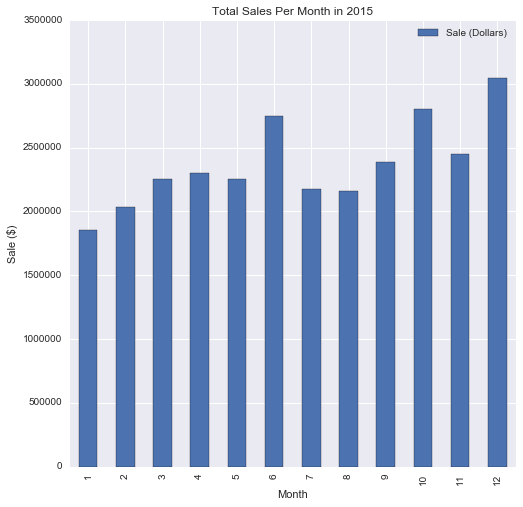

In [11]:
#Plotted a distribution of total sales per month in 2015
monthly_sales_2015 = liquor_2015[['Sale (Dollars)','Month']].groupby(['Month']).sum()
month_sales_15 = monthly_sales_2015.plot(kind='bar',figsize=(8,8))
month_sales_15.set_ylabel('Sale ($)')
month_sales_15.set_title('Total Sales Per Month in 2015')
#monthly_sales_2015

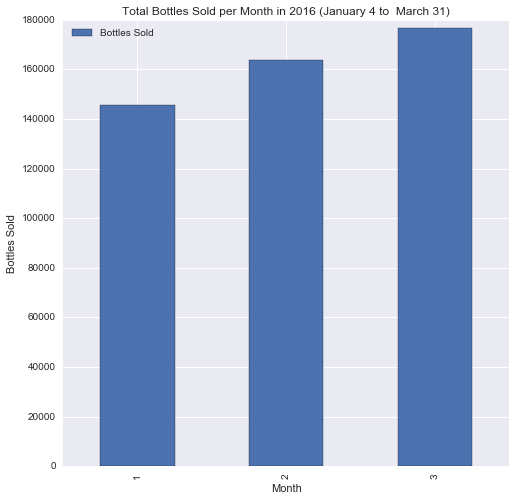

In [12]:
#Plotted a distribution of total bottles sold in 2016 for only January, February, and March
liquor_2016 = liquor[~date_mask].sort_values(by=['Date'])
bottles_sold = liquor_2016[['Bottles Sold','Month']].groupby(['Month']).sum()
bottles_vs_month = bottles_sold.plot(kind='bar', figsize=(8,8))
bottles_vs_month.set_ylabel('Bottles Sold')
bottles_vs_month.set_title('Total Bottles Sold per Month in 2016 (January 4 to  March 31)')

In [13]:
# Determine which stores were open all of 2015
# Find the first and last sales date.
dates = liquor.groupby(by=["Store Number"], as_index=False)
dates = dates.agg({"Date": [np.min, np.max]})
dates.columns = [' '.join(col).strip() for col in dates.columns.values]
dates.head()

# Filter out stores that opened or closed throughout the year
# You may want to save this step until you start modelling
lower_cutoff = pd.Timestamp("20150301")
upper_cutoff = pd.Timestamp("20151001")
mask = (dates['Date amin'] < lower_cutoff) & (dates['Date amax'] > upper_cutoff)
good_stores = dates[mask]["Store Number"]
liquor = liquor[liquor["Store Number"].isin(good_stores)]
dates.shape

(1378, 3)

In [14]:
#Checked the shape of the stores opened
good_stores.shape

(1161,)

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [15]:
#Sort only sales for 2015, used "mask" as my timeframe
sales = liquor[date_mask]

#Used groupby to "Store Number"
sales = sales.groupby(['Store Number'],as_index=False)

#Assigned columns to calculate the sum and mean of Sales, Volume Sold (Liters), Margin, and Price per Liter
#Also held the Zip Code, City, and County Number
sales = sales.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

#Columns were messy so had to combined them down one
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

#Renmaed the messy columns
sales.rename(columns={'City <lambda>':'City',
                      'Sale (Dollars) sum': '2015 Sales',
                      'Sale (Dollars) mean': '2015 Sales Mean',
                      'County Number <lambda>':'County Number',
                      'Zip Code <lambda>': 'Zip Code',
                      'Margin mean': '2015 Margin mean'
                      }, inplace=True)

# Quick check
sales.head()

/Users/jrcmalunay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Store Number,City,2015 Sales,2015 Sales Mean,County Number,Price per Liter mean,Zip Code,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2015 Margin mean
0,2106,CEDAR FALLS,146038.70,277.640114,7,17.844997,50613,9719.85,18.478802,92.665779
1,2113,GOWRIE,9310.22,63.334830,94,18.507700,50543,659.85,4.488776,21.149932
2,2130,WATERLOO,111583.91,285.380844,7,16.817589,50703,6879.37,17.594297,95.215652
3,2152,ROCKWELL,7721.08,54.759433,17,13.020765,50469,633.37,4.491986,18.351277
4,2178,WAUKON,24324.18,102.633671,3,16.053844,52172,1917.12,8.089114,34.454430


In [16]:
sales.shape

(1161, 10)

In [17]:
#Sort only sales for 2016, used "mask" as my timeframe. This case, took the OPPOSITE of "~" mask to get 2016 
sales2 = liquor[~date_mask]

#Used groupby to "Store Number"
sales2 = sales2.groupby(['Store Number'],as_index=False)

#Assigned columns to calculate the sum and mean of Sales, Volume Sold (Liters), Margin, and Price per Liter
#Also held the Zip Code, City, and County Number
sales2 = sales2.agg({"Sale (Dollars)": [np.sum, np.mean],
                   "Volume Sold (Liters)": [np.sum, np.mean],
                   "Margin": np.mean,
                   "Price per Liter": np.mean,
                   "Zip Code": lambda x: x.iloc[0], 
                   "City": lambda x: x.iloc[0],
                   "County Number": lambda x: x.iloc[0]})

#Columns were messy so had to combined them down one
sales2.columns = [' '.join(col).strip() for col in sales2.columns.values]

#Renmaed the messy columns
sales2.rename(columns={'City <lambda>':'City',
                      'Sale (Dollars) sum': '2016 Sales',
                      'Sale (Dollars) mean': '2016 Sales Mean',
                      'County Number <lambda>':'County Number',
                      'Zip Code <lambda>': 'Zip Code',
                       'Margin mean': '2016 Margin mean'
                      }, inplace=True)

# Quick check
sales2.head()

/Users/jrcmalunay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,Store Number,City,2016 Sales,2016 Sales Mean,County Number,Price per Liter mean,Zip Code,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2016 Margin mean
0,2106,CEDAR FALLS,30478.75,241.894841,7,17.969769,50613,2116.25,16.795635,80.751429
1,2113,GOWRIE,2065.90,55.835135,94,17.483024,50543,177.00,4.783784,18.742973
2,2130,WATERLOO,27856.11,238.086410,7,17.452157,50703,1556.90,13.306838,79.387094
3,2152,ROCKWELL,904.66,45.233000,17,12.487833,50469,87.50,4.375000,15.204000
4,2178,WAUKON,5588.50,96.353448,3,15.101929,52172,520.80,8.979310,32.220000


In [18]:
#Filtered out the dates for only the first three months to get the total sales for 2015 using a mask
quarter_mask = (liquor['Date'] >= '2015-01-01') & (liquor['Date'] <= '2015-03-31')
df2 = liquor[quarter_mask].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2015 Sales Q1"] = df2["Sale (Dollars)"]
sales.head()

#Filtered out the dates for only the first three months to get the total sales for 2016 using a mask
quarter_mask2 = (liquor['Date'] >= '2016-01-01') & (liquor['Date'] <= '2016-03-31')
df2 = liquor[quarter_mask2].groupby(by=["Store Number"], as_index=False)["Sale (Dollars)"].sum()
sales["2016 Sales Q1"] = df2["Sale (Dollars)"]
sales.head()

,Store Number,City,2015 Sales,2015 Sales Mean,County Number,Price per Liter mean,Zip Code,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1
0,2106,CEDAR FALLS,146038.70,277.640114,7,17.844997,50613,9719.85,18.478802,92.665779,39287.29,30478.75
1,2113,GOWRIE,9310.22,63.334830,94,18.507700,50543,659.85,4.488776,21.149932,2833.25,2065.90
2,2130,WATERLOO,111583.91,285.380844,7,16.817589,50703,6879.37,17.594297,95.215652,24272.57,27856.11
3,2152,ROCKWELL,7721.08,54.759433,17,13.020765,50469,633.37,4.491986,18.351277,2003.46,904.66
4,2178,WAUKON,24324.18,102.633671,3,16.053844,52172,1917.12,8.089114,34.454430,5856.41,5588.50


# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [19]:
#Made sure there are no null values
del sales['County Number']
true_sales = sales.dropna()
true_sales.shape

(1143, 11)

In [20]:
#Assigned a new data frame to locate which top cities had most sales by Margin mean
sales_location = pd.DataFrame(true_sales.ix[0:,'City':])
sales_city = sales_location.groupby(by='City',as_index=False).sum()

city_margin_2015_mean = sales_city.sort_values(by='2015 Margin mean', ascending=False)

top_city_sales = city_margin_2015_mean.head(10)
top_city_sales
#city_margin_2016_mean = sales_city.sort_values(by='2016 Margin mean', ascending=False)

,City,2015 Sales,2015 Sales Mean,Price per Liter mean,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1
80,DES MOINES,3284018.32,8034.620848,1282.174167,203319.68,513.619896,2683.077842,714571.55,331501.25
48,CEDAR RAPIDS,2004464.46,7427.952104,1113.073062,139129.79,528.706642,2482.061782,441312.08,294449.37
74,DAVENPORT,1379456.69,5756.856265,738.211925,93026.46,389.530724,1922.315005,270752.59,186964.17
330,WEST DES MOINES,937986.09,4925.046800,484.152197,57044.25,294.305504,1649.248447,217424.40,120036.63
69,COUNCIL BLUFFS,936821.88,4847.409448,605.925828,63664.46,332.024479,1618.407788,215337.82,336048.37
319,WATERLOO,944510.45,4709.245312,608.883911,63975.40,317.395901,1573.082963,196405.72,185324.93
279,SIOUX CITY,943006.01,4002.664015,550.425389,63371.68,271.363439,1337.941794,220270.20,214912.79
82,DUBUQUE,794821.19,3547.897661,439.700861,58027.11,261.408130,1188.001224,168930.87,97651.45
11,AMES,803910.81,3190.842058,414.770467,54922.33,231.132621,1066.790853,187593.12,115876.84
66,CORALVILLE,516438.37,3073.255703,185.882218,29669.21,159.598222,1025.766313,80360.61,15795.30


In [21]:
#Updated the dataframe to take out the city
sales_update = sales.ix[:,'2015 Sales':]
sales_update.head()

,2015 Sales,2015 Sales Mean,Price per Liter mean,Zip Code,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1
0,146038.70,277.640114,17.844997,50613,9719.85,18.478802,92.665779,39287.29,30478.75
1,9310.22,63.334830,18.507700,50543,659.85,4.488776,21.149932,2833.25,2065.90
2,111583.91,285.380844,16.817589,50703,6879.37,17.594297,95.215652,24272.57,27856.11
3,7721.08,54.759433,13.020765,50469,633.37,4.491986,18.351277,2003.46,904.66
4,24324.18,102.633671,16.053844,52172,1917.12,8.089114,34.454430,5856.41,5588.50


In [22]:
#Checked the shape of the sales_update 
sales_update_nan = sales_update.dropna()
sales_update_nan.isnull().sum()

2015 Sales                   0
2015 Sales Mean              0
Price per Liter mean         0
Zip Code                     0
Volume Sold (Liters) sum     0
Volume Sold (Liters) mean    0
2015 Margin mean             0
2015 Sales Q1                0
2016 Sales Q1                0
dtype: int64

In [23]:
#Normalized the dataframe to find any correlations
sales_corr = sales_update.corr()
sales_corr

,2015 Sales,2015 Sales Mean,Price per Liter mean,Volume Sold (Liters) sum,Volume Sold (Liters) mean,2015 Margin mean,2015 Sales Q1,2016 Sales Q1
2015 Sales,1.000000,0.424749,0.166345,0.992384,0.416233,0.424300,0.983281,0.149051
2015 Sales Mean,0.424749,1.000000,0.189559,0.416770,0.913159,0.999977,0.395482,0.021464
Price per Liter mean,0.166345,0.189559,1.000000,0.123705,-0.056151,0.187951,0.160362,-0.017654
Volume Sold (Liters) sum,0.992384,0.416770,0.123705,1.000000,0.437835,0.416575,0.974637,0.166283
Volume Sold (Liters) mean,0.416233,0.913159,-0.056151,0.437835,1.000000,0.914510,0.392520,0.026788
2015 Margin mean,0.424300,0.999977,0.187951,0.416575,0.914510,1.000000,0.395189,0.021345
2015 Sales Q1,0.983281,0.395482,0.160362,0.974637,0.392520,0.395189,1.000000,0.152734
2016 Sales Q1,0.149051,0.021464,-0.017654,0.166283,0.026788,0.021345,0.152734,1.000000


# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [24]:
#Loaded packages for modeling
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

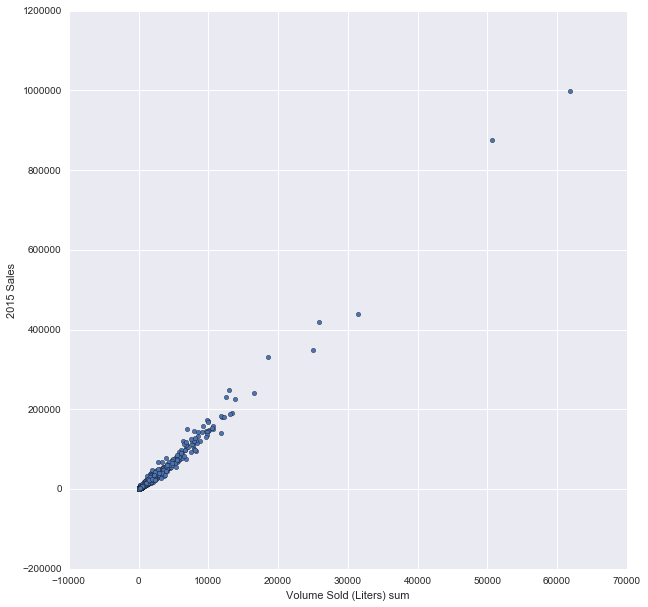

In [49]:
#Created a scatter plot using the Volume Sold (LIters) sum and 2015 Sales
sales_update_nan.plot.scatter(x='Volume Sold (Liters) sum',y ='2015 Sales')

Model fit: 0.984964239676
15.7040722438 -2281.74448685


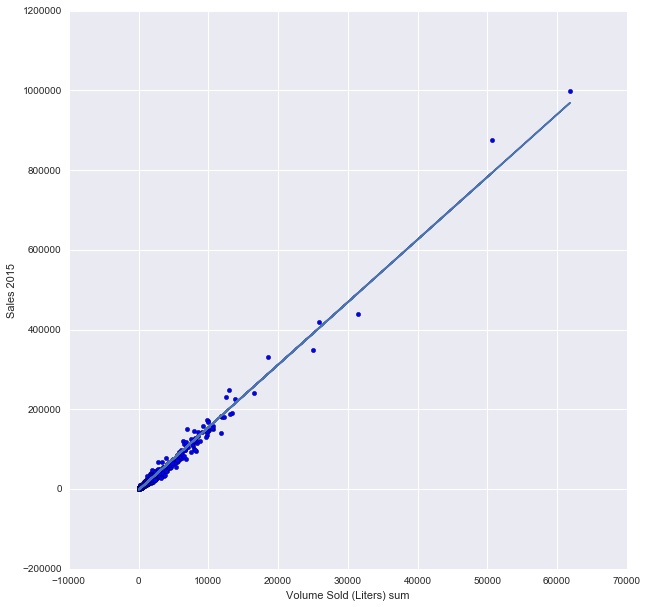

In [50]:
# Fited a model to find a Linear Regression

lm = linear_model.LinearRegression()
X = sales_update_nan[["Volume Sold (Liters) sum"]]
y = sales_update_nan["2015 Sales"]
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)
print lm.coef_[0], lm.intercept_

# Plotted the model
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Volume Sold (Liters) sum")
plt.ylabel("Sales 2015")
plt.show()

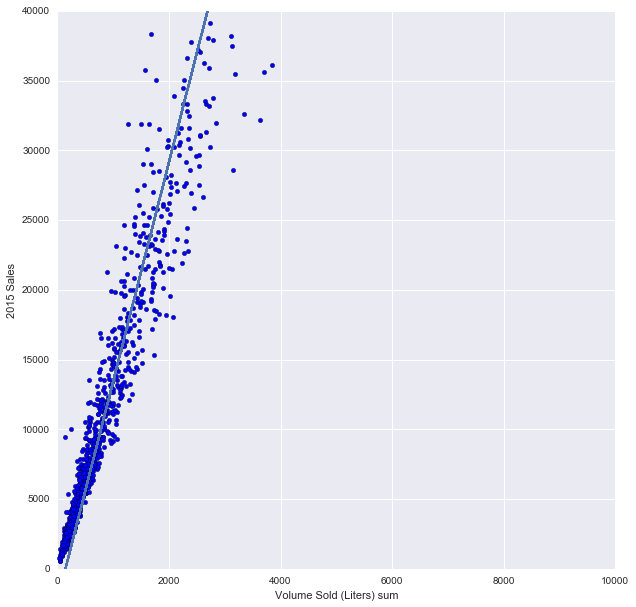

In [51]:
# Zoomed in on the lower corner
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Volume Sold (Liters) sum")
plt.ylabel("2015 Sales")
plt.xlim(0, 10000)
plt.ylim(0, 40000)
plt.show()

In [56]:
# Predicted 2016 sales, compared to 2015

X = sales_update_nan[["2015 Sales"]]
predictions = lm.predict(X)
total_2016 = sum(predictions)
total_2015 = sum(sales_update_nan["Volume Sold (Liters) sum"])
X2 = sales_update_nan[["Volume Sold (Liters) sum"]]
pred_2015 = sum(lm.predict(X2))

print "2015 predicted", pred_2015
print "2015 actual", total_2015
print "2016 predicted", total_2016


2015 predicted 27036627.4
2015 actual 1887705.36
2016 predicted 421977115.97


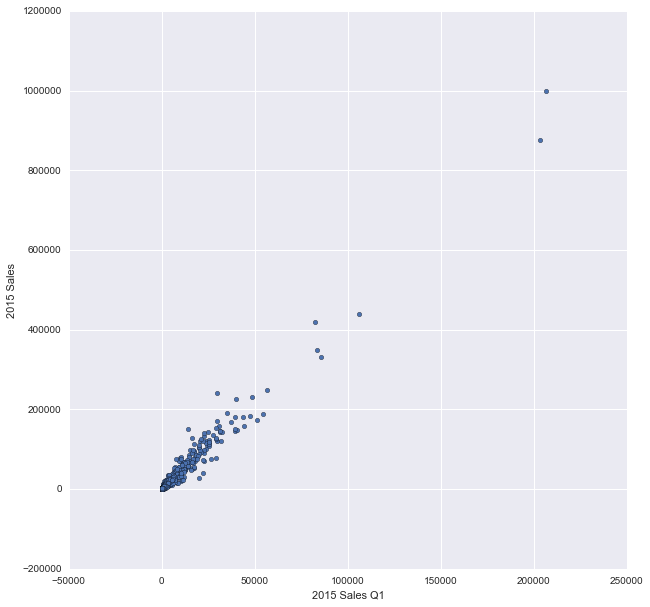

In [29]:
#Created a scatter plot between 2015 Sales Q1 and 2015 Sales
sales_update_nan.plot.scatter(x='2015 Sales Q1',y ='2015 Sales')

Model fit: 0.967834535214
4.46318267805 603.483428211


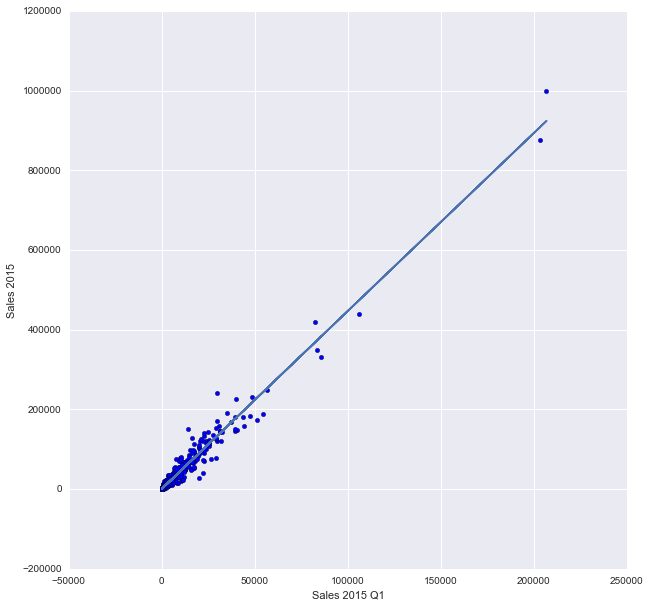

In [30]:
# Fit model to find a Linear Regression

lm = linear_model.LinearRegression()
X = sales_update_nan[["2015 Sales Q1"]]
y = sales_update_nan["2015 Sales"]
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)
print lm.coef_[0], lm.intercept_

# Plotted the data
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("Sales 2015 Q1")
plt.ylabel("Sales 2015")
plt.show()

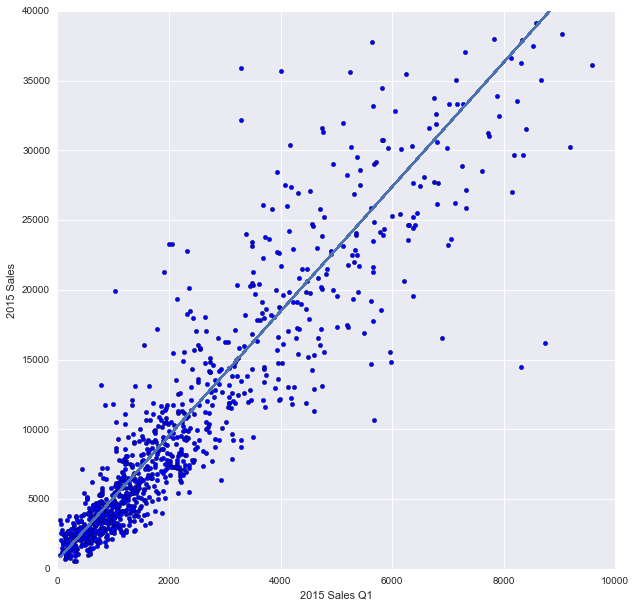

In [31]:
# Zoomed in on the lower corner
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("2015 Sales Q1")
plt.ylabel("2015 Sales")
plt.xlim(0, 10000)
plt.ylim(0, 40000)
plt.show()

In [32]:
# Predicted 2016 sales, compared to 2015

X = sales_update_nan[["2016 Sales Q1"]]
predictions = lm.predict(X)
total_2016 = sum(predictions)
total_2015 = sum(sales_update_nan["2015 Sales"])
X2 = sales_update_nan[["2015 Sales Q1"]]
pred_2015 = sum(lm.predict(X2))

print "2015 predicted", pred_2015
print "2015 actual", total_2015
print "2016 predicted", total_2016


2015 predicted 27036627.4
2015 actual 27036627.4
2016 predicted 27020745.5215


# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

Scenario 2:

As a business owner, location is key for settting up shop. In Iowa, liquor stores generate a variety of sales based on location. Where should a business man/woman invest his/her money? Based on the dataset, I have taken the sales from 2015 based on sum, mean, margin, and volume. With this, I was able to figure out which cities produced the most revenue. In doing so, I first determined which stores were open throughout 2015. The data set was quite large - about 2.7 million inputs, so I only took in 10% of it. Out of the 270,000 inputs, I grouped them by the stores and narrowed them down to 1161 stores. After, I grouped them by the cities based on their Margin mean in 2015. The top ten cities are: DES MOINES, CEDAR RAPIDS, DAVENPORT, WEST DES MOINES, COUNCIL BLUFFS, WATERLOO, SIOUX CITY, DUBUQUE, AMES, CORALVILLE. Soley, based on these cities, I modeled a linear regression to visualzie the relationship between sum of Volume Sold and their 2015 sales. The model fit well by about 98%. Over 27 million liters were sold with a prediction of 27.1 liters. Soley on these 10 stores, there is a prediction of 96 million litiers to be sold in 2016. These are stores a business man/woman should open up their stores. I did a similar model for the prediciton of sales in 2016. 